In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn import metrics
import sys
import copy
import statsmodels.api as sm
pd.options.mode.chained_assignment = None
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000
%matplotlib inline

dfTemp=pd.read_csv(r'C:\Users\Jaesung Park\Desktop\FP\GroupProject\kc_house_data.csv',keep_default_na=False)

In [2]:
data = dfTemp.reindex(np.random.permutation(dfTemp.index))
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('id')
data.price = data.price.astype(int)
data.bathrooms = data.bathrooms.astype(int)
data.floors = data.floors.astype(int)
data["house_age"] = data["date"].dt.year - data['yr_built']
data['renovated'] = data['yr_renovated'].apply(lambda yr: 0 if yr == 0 else 1)

data=data.drop('date', axis=1)
data=data.drop('yr_renovated', axis=1)
data=data.drop('yr_built', axis=1)

dataset = data[data.columns.difference(['id', 'long'])]
#X = dataset[['house_age','sqft_living','grade','condition', 
#'sqft_living15','bathrooms','view','sqft_basement','floors','waterfront',
#'renovated','bedrooms']]


In [3]:
#doesn't need for ridge
#dataset['price'] = np.log(dataset['price'])

In [4]:
fall = [] # 1빼고 다 넣은 리스트
for i in range(len(dataset.columns)):
    if dataset.columns[i] in ([]):
        fall.append(dataset.columns[i])

five = [] # 1빼고 다 넣은 리스트
for i in range(len(dataset.columns)):
    if dataset.columns[i] not in (['price', 'sqft_living']):
        five.append(dataset.columns[i])
        
fifthteen = [] # 2빼고 다 넣은 리스트
for i in range(len(dataset.columns)):
    if dataset.columns[i] not in (['price', 'sqft_living','grade']):
        fifthteen.append(dataset.columns[i])

thirty = [] # 4빼고 다 넣은 리스트
for i in range(len(dataset.columns)):
    if dataset.columns[i] not in (['price', 'sqft_living','sqft_above','grade','sqft_living15']):
        thirty.append(dataset.columns[i])    

half = [] # 반타작
for i in range(len(dataset.columns)):
    if dataset.columns[i] not in (['price','sqft_living','sqft_above','grade','sqft_living15',
       'bathrooms', 'view']):
        half.append(dataset.columns[i])
        
seventy = [] # 8 in
for i in range(len(dataset.columns)):
    if dataset.columns[i] in (['condition', 'house_age','zipcode', 'sqft_lot15']):
        seventy.append(dataset.columns[i]) 
        
eightyfive = [] # 10 in
for i in range(len(dataset.columns)):
    if dataset.columns[i] in (['condition', 'house_age']):
        eightyfive.append(dataset.columns[i]) 
        
ninetyfive = [] # 11 in
for i in range(len(dataset.columns)):
    if dataset.columns[i] in (['condition']):
        ninetyfive.append(dataset.columns[i]) 


In [5]:
#regressor = LinearRegression(fit_intercept=True)

alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1,0.5, 1, 10, 15, 20, 30, 40, 100]
regressor=RidgeCV(alphas=alphas, store_cv_values=True)


In [6]:
## exclude the lefts
rounded = round(dataset.shape[0]/10)*10
left = dataset.shape[0] - rounded
left

3

In [7]:
testing = dataset
testing2 = dataset.iloc[left:]

In [8]:
k = testing2.shape[0]
fold = 10
point = round(k/fold)
mylist = []

start = 0
end= point

In [9]:
# separating dataset into # number of folds and put each fold into list
for i in range(fold):
    x = testing2.iloc[start:end]
    start = start + point
    end = end + point
    mylist.append(x)

In [10]:
RidgeCV_MAE = []
RidgeCV_MSE = []
RidgeCV_RMSE = []
alphasL = []
r2_list = []
predicted = []

In [11]:
temp = copy.deepcopy(mylist)

In [12]:
hm = fall

for j in range(fold):
    mylist = copy.deepcopy(temp)
    testing_set = mylist[j]
    appended_data = []
    for z in range(fold):
        if not z == j:
            appended_data.append(mylist[z])
            
    training_set = pd.concat(appended_data, ignore_index = True)
    
    
    #mean imputation
    for p in range(len(testing_set.columns)):
        if testing_set.columns[p] in hm:
            testing_set[testing_set.columns[p]] = np.mean(training_set[training_set.columns[p]])
           
    
    testing_set_X = testing_set[testing.columns.difference(['price'])]
    testing_set_Y = testing_set['price']
    training_set_X = training_set[testing.columns.difference(['price'])]
    training_set_Y = training_set['price']

    ridge_mod = regressor.fit(training_set_X, training_set_Y)
    alphasL.append(ridge_mod.alpha_)
    y_pred = regressor.predict(testing_set_X)
    MAE = metrics.mean_absolute_error(testing_set_Y, y_pred)
    MSE = metrics.mean_squared_error(testing_set_Y, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(testing_set_Y, y_pred))
    r2 = metrics.r2_score(testing_set_Y, y_pred)
    py = y_pred
    
    RidgeCV_MAE.append(MAE)
    RidgeCV_MSE.append(MSE)
    RidgeCV_RMSE.append(RMSE)
    r2_list.append(r2)
    predicted.append(py)


In [13]:
np.mean(RidgeCV_MAE)

126053.29981389534

In [14]:
np.mean(RidgeCV_MSE)

41253582413.60292

In [15]:
np.mean(RidgeCV_RMSE)

202406.59907705715

In [16]:
alphasL

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [17]:
np.mean(r2_list)

0.6944388309221393

In [18]:
cd = np.concatenate(predicted)
ab = testing2['price']

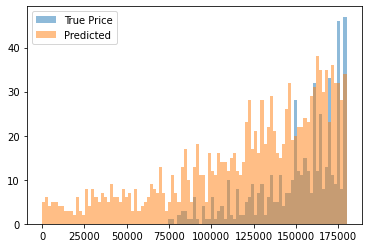

In [19]:
import numpy
bins = numpy.linspace(0, 180000, 100)
plt.hist(ab, bins, alpha=0.5, label='True Price')
plt.hist(cd, bins, alpha=0.5, label='Predicted')
plt.legend(loc='upper left')

plt.show()